In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
df = pd.read_csv("KiK-Net_cleaned.csv")

# Select relevant features and drop NA
features = ['Magnitude', 'Vs30', 'Depth(Km)', 'Tectonic_Garcia', 'Focal_mechanism_Garcia', 'r(rupture)']
df = df[features + ['pga(g)']].dropna()

df.head()

,Magnitude,Vs30,Depth(Km),Tectonic_Garcia,Focal_mechanism_Garcia,r(rupture),pga(g)
0,3.7,342.039161,11,2,0,95.910519,0.047758
1,3.7,423.149362,11,2,0,88.866137,0.014684
2,3.7,434.928454,11,2,0,108.518168,0.016673
3,4.2,241.153846,11,2,2,89.349912,0.596137
4,4.2,301.324503,11,2,2,96.608195,0.156011


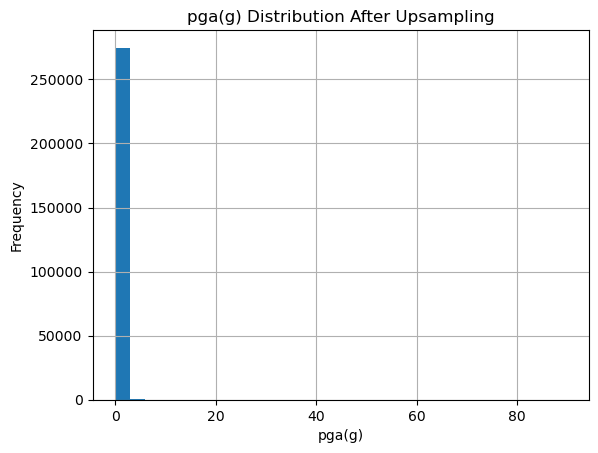

In [3]:
# Bin the target variable for upsampling
df['PGA_bin'] = pd.qcut(df['pga(g)'], q=4, labels=False)

# Upsample minority classes
dfs = []
max_size = df['PGA_bin'].value_counts().max()
for class_index, group in df.groupby('PGA_bin'):
    dfs.append(group.sample(max_size, replace=True, random_state=42))
df_upsampled = pd.concat(dfs).drop('PGA_bin', axis=1).reset_index(drop=True)

df_upsampled['pga(g)'].hist(bins=30)
plt.title('pga(g) Distribution After Upsampling')
plt.xlabel('pga(g)')
plt.ylabel('Frequency')
plt.show()

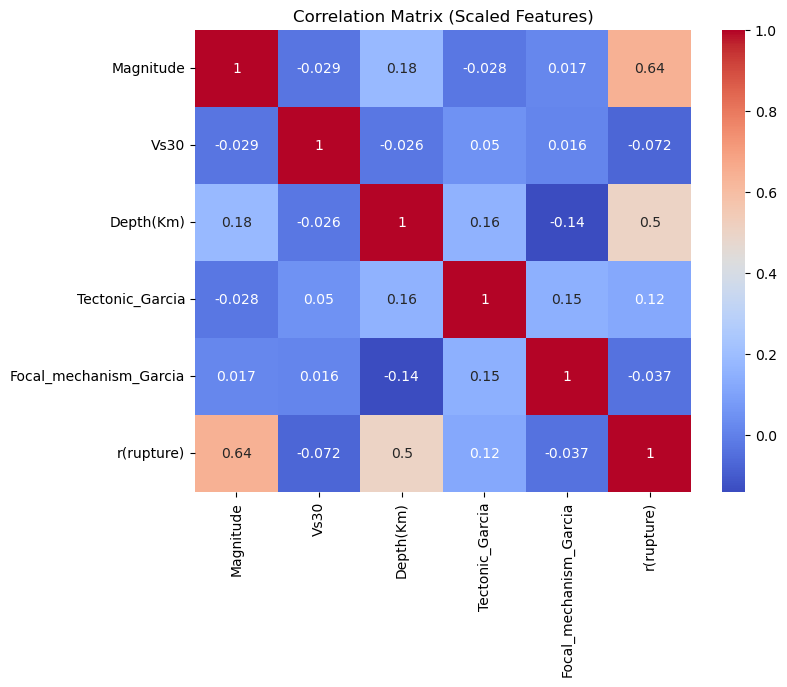

In [4]:
# Correlation matrix on scaled features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_upsampled[features])
scaled_df = pd.DataFrame(scaled_features, columns=features)

plt.figure(figsize=(8, 6))
sns.heatmap(scaled_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Scaled Features)")
plt.show()

In [5]:
# Split and train
X = df_upsampled[features]
y = df_upsampled['pga(g)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [6]:
# Evaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

RMSE: 0.6478548857580569
MAE: 0.14503193627760322
R²: 0.06442346235956908


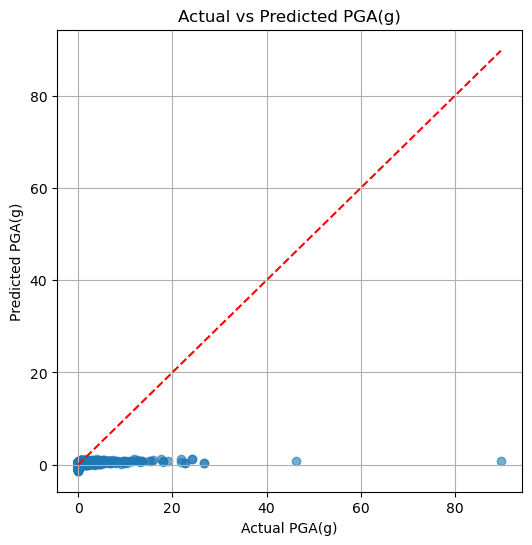

In [8]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor= None )
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual PGA(g)')
plt.ylabel('Predicted PGA(g)')
plt.title('Actual vs Predicted PGA(g)')
plt.grid(True)
plt.show()

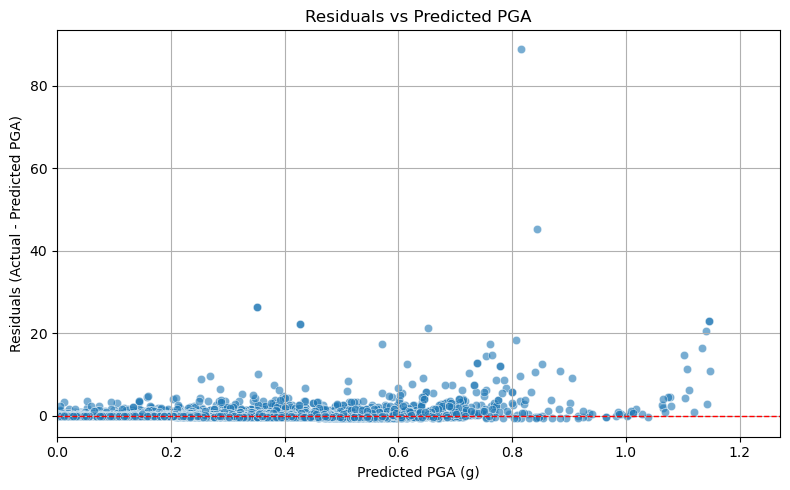

In [9]:
residuals = y_test - y_pred

# Create the plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)

# Add horizontal line at y = 0
plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Set plot labels and limits
plt.xlabel("Predicted PGA (g)")
plt.ylabel("Residuals (Actual - Predicted PGA)")
plt.title("Residuals vs Predicted PGA")

# Show only positive values on x-axis
plt.xlim(left=0)

# Let y-axis show both negative and positive residuals naturally
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd

# Define custom PGA bins and labels
pga_bins = [0.0, 0.1, 1.0, float('inf')]
pga_labels = ["Low", "Moderate", "High"]

# Function to bin PGA values
def bin_pga(values, bins=pga_bins, labels=pga_labels):
    return pd.cut(values, bins=bins, labels=labels, right=False, include_lowest=True)

# Bin the true and predicted PGA values
y_true_class = bin_pga(y_test)
y_pred_class = bin_pga(y_pred)

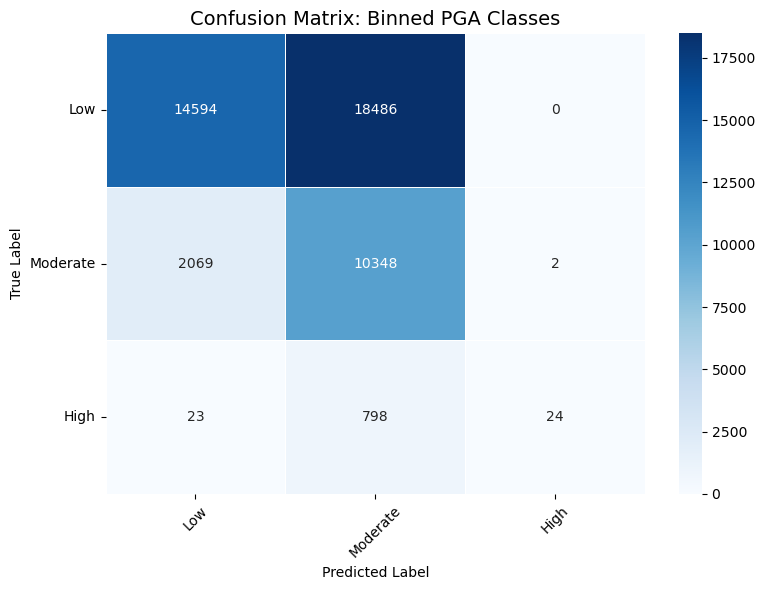

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_clean_confusion_matrix(y_true_class, y_pred_class, labels=pga_labels, title="Confusion Matrix: Binned PGA Classes"):
    cm = confusion_matrix(y_true_class.astype(str), y_pred_class.astype(str), labels=[str(l) for l in labels])
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=0.5)
    plt.title(title, fontsize=14)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_clean_confusion_matrix(y_true_class, y_pred_class)

In [12]:
print("\n=== Classification Report ===")
print(classification_report(y_true_class.astype(str), y_pred_class.astype(str), labels=pga_labels, zero_division=0))

acc = accuracy_score(y_true_class.astype(str), y_pred_class.astype(str))
print(f"\nOverall Accuracy: {acc:.4f}")


=== Classification Report ===
              precision    recall  f1-score   support

         Low       0.87      0.35      0.50     41463
    Moderate       0.35      0.81      0.49     12801
        High       0.92      0.03      0.05       849

   micro avg       0.54      0.45      0.49     55113
   macro avg       0.72      0.40      0.35     55113
weighted avg       0.75      0.45      0.49     55113


Overall Accuracy: 0.4530
